# Objective 1: Predict Death 

Load the Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

data = pd.read_csv('data/custom_covid19.csv') 
print("Data loaded with shape:", data.shape)
print(data.columns.tolist())


Data loaded with shape: (100000, 21)
['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'TEST_RESULT', 'ICU']


#### 1. Create target variable

In [2]:

data['DIED'] = data['DATE_DIED'].apply(lambda x: 0 if x == '9999-99-99' else 1)

#### 2. Mark missing values

In [3]:
nan_count_before = data.isna().sum()

data.replace([97, 98, 99], np.nan, inplace=True)

nan_count_after = data.isna().sum()

print("NaN counts after replacement:\n", nan_count_after)

NaN counts after replacement:
 USMER                 0
MEDICAL_UNIT          0
SEX                   0
PATIENT_TYPE          0
DATE_DIED             0
INTUBED           81491
PNEUMONIA          1577
AGE                  31
PREGNANT            352
DIABETES            343
COPD                295
ASTHMA              287
INMSUPR             331
HYPERTENSION        301
OTHER_DISEASE       456
CARDIOVASCULAR      294
OBESITY             276
RENAL_CHRONIC       295
TOBACCO             326
TEST_RESULT           0
ICU               81502
DIED                  0
dtype: int64


#### 3. Convert boolean variables

In [4]:
bool_cols = ['INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 
             'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 
             'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']
data[bool_cols] = data[bool_cols].replace(2, 0)

#### 4. Create COVID status feature

In [5]:
data['COVID_POSITIVE'] = data['TEST_RESULT'].apply(lambda x: 1 if x in [1,2,3] else 0)

#### 5. Define features to keep/drop

In [6]:
features_to_keep = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 
                   'INTUBED', 'PNEUMONIA', 'AGE', 'DIABETES', 'COPD',
                   'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE',
                   'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO',
                   'ICU', 'COVID_POSITIVE']

# 6. Separate features and target
x = data[features_to_keep]
y = data['DIED']


#### 6. Define preprocessing pipeline

In [7]:
# Option 1: Delete all rows with any NaN values
data_option1 = data.copy()
print(f"Original data size: {len(data_option1)} rows")



# Drop all rows with any NaN values
# data_option1_clean = data_option1[].dropna()
data_option1_clean = data_option1
data_option1_clean['ICU'].replace(np.nan, 0 , inplace=True)
data_option1_clean['INTUBED'].replace(np.nan, 0 , inplace=True)



# Drop rows with any NaN values
data_option1_clean = data_option1_clean.dropna()

# nan_count_after = data_option1_clean.isna().sum()

# print("NaN counts after replacement:\n", nan_count_after)

# nan_count_after_clean = data_option1_clean.isna().sum()
# print("NaN counts after cleaning:\n", nan_count_after_clean)


print(f"After dropping NaNs: {len(data_option1_clean)} rows ({len(data_option1)-len(data_option1_clean)} rows removed)")
print(f"Percentage kept: {len(data_option1_clean)/len(data_option1)*100:.2f}%")


# Prepare features and target for Option 1
x = data_option1_clean[features_to_keep]
y = data_option1_clean['DIED']

Original data size: 100000 rows
After dropping NaNs: 97381 rows (2619 rows removed)
Percentage kept: 97.38%


C:\Users\tor\AppData\Local\Temp\ipykernel_9752\1672624776.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_option1_clean['ICU'].replace(np.nan, 0 , inplace=True)
C:\Users\tor\AppData\Local\Temp\ipykernel_9752\1672624776.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [8]:
numeric_features = ['AGE']
categorical_features = [col for col in features_to_keep 
                       if col not in numeric_features + ['DIED', 'COVID_POSITIVE']]

# Numeric pipeline (mean imputation + scaling)
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline (mode imputation)
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Combined preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Verification
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['AGE']
Categorical features: ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']


#### 8. Train-Test split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {x_train.shape}, Test set: {x_test.shape}")
print(f"Class distribution (train): {pd.Series(y_train).value_counts(normalize=True)}")

Training set: (77904, 19), Test set: (19477, 19)
Class distribution (train): DIED
0    0.927051
1    0.072949
Name: proportion, dtype: float64


#### 9. Model Evaluation

1. Evaluation Setup

In [10]:
# We'll evaluate three baseline classifiers:
# 1. Naive Bayes (probabilistic)
# 2. K-Nearest Neighbors (instance-based)
# 3. Linear Support Vector Classifier (linear decision boundary)

import os
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Visualization settings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 4)
sns.set_palette("husl")
# Ensure 'figures' directory exists
os.makedirs("figures", exist_ok=True)

2. Evaluation function

In [11]:
def evaluate_model(name, model, x_train, y_train, x_test, y_test):
    """
    Evaluates a classification model and generates report-ready outputs.

    Parameters:
    - name: str, model name for display
    - model: sklearn classifier object
    - X_train, X_test, y_train, y_test: training/test data

    Returns:
    - Dictionary containing metrics and visualization paths
    """

    #create pipeline with preprocessor and model
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(x_train, y_train)

    # Predict on test set
    y_pred = pipeline.predict(x_test)
    


    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    confusion_matrix_df = confusion_matrix(y_test, y_pred)

    #create visualization 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Confusion matrix heatmap
    sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Survived', 'Died'],
                yticklabels=['Survived', 'Died'])
    ax1.set_title(f'{name} Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # Metrics bar plot
    metrics = ['precision', 'recall', 'f1-score', 'support']
    ax2.set_xticklabels(metrics, rotation=45)
    scores = [report['weighted avg'][m] for m in metrics]
    sns.barplot(x=metrics, y=scores, ax=ax2)
    ax2.set_title(f'{name} Performance Metrics')
    ax2.set_ylim(0, 1)

    # Save the figure
    fig_path = f'figures/O1_{name.lower().replace(" ", "_")}_performance.png'
    plt.tight_layout()
    plt.savefig(fig_path)
    plt.close()
    
    # # Display outputs in the notebook
    # display(Markdown(f"## {name} Performance"))
    # display(Markdown("### Classification Report"))
    # print(classification_report(y_test, y_pred))

    # display(Markdown("### Confusion Matrix"))
    # print(confusion_matrix_df)

    return {
        'model': name,
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'figure_path': fig_path
    }

3. Model Definitions

In [12]:

#### Baseline Model Definitions
# We select three distinct algorithmic approaches:

models = [
    ('Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5)),
    ('Support Vector Machine', LinearSVC(random_state=42, class_weight='balanced')) 
]

4. Model execution/evaluation

In [13]:
# === Evaluate All Baseline Models ===

model_results = []

for name, model in models:
    result = evaluate_model(name, model, x_train, y_train, x_test, y_test)
    model_results.append(result)

C:\Users\tor\AppData\Local\Temp\ipykernel_9752\3892657113.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(metrics, rotation=45)
C:\Users\tor\AppData\Local\Temp\ipykernel_9752\3892657113.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(metrics, rotation=45)
C:\Users\tor\AppData\Local\Temp\ipykernel_9752\3892657113.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(metrics, rotation=45)


#### 10. Hyperperameter Optimization
We implement systematic hyperparameter tuning for all three models using GridSearchCV (exhaustive search) to find optimal parameters.

A. Naive Bayes (GaussianNB)

In [14]:
param_grid_nb = {
    'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7]  
}

B. K-Nearest Neighbors (KNN)

In [15]:
param_grid_knn = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]
}

C. Support Vector Classifier (SVC)

In [16]:
param_grid_svm = {
    'svc__C': [0.01, 0.1, 1, 10]  
}

#### 11. Implementation with Cross-Validation

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

#create pipelines for each model
pipeline_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('gaussiannb', GaussianNB())
])

pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('kneighborsclassifier', KNeighborsClassifier())
])

pipeline_svc = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', LinearSVC(random_state=42, class_weight='balanced'))
])

# Perform grid search for each model
grid_nb = GridSearchCV(pipeline_nb, param_grid_nb, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_svc = GridSearchCV(pipeline_svc, param_grid_svm, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)

# Fit each grid search on the training data
grid_nb.fit(x_train, y_train)
grid_knn.fit(x_train, y_train)
grid_svc.fit(x_train, y_train)

print("Naive Bayes best params:", grid_nb.best_params_)
print("KNN best params:", grid_knn.best_params_)
print("Linear SVC best params:", grid_svc.best_params_)



Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Naive Bayes best params: {'gaussiannb__var_smoothing': 1e-09}
KNN best params: {'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
Linear SVC best params: {'svc__C': 0.01}


#### 12. Valuation Using DecisionTree

Optimizing Decision Tree...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
=== Decision Tree Performance ===

Best Parameters:
{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 15, 'decisiontreeclassifier__max_features': 'sqrt', 'decisiontreeclassifier__min_samples_leaf': 8, 'decisiontreeclassifier__min_samples_split': 20}

Classification Report:
              precision    recall  f1-score   support

       Alive       0.96      0.98      0.97     18056
        Died       0.67      0.42      0.52      1421

    accuracy                           0.94     19477
   macro avg       0.81      0.70      0.74     19477
weighted avg       0.94      0.94      0.94     19477



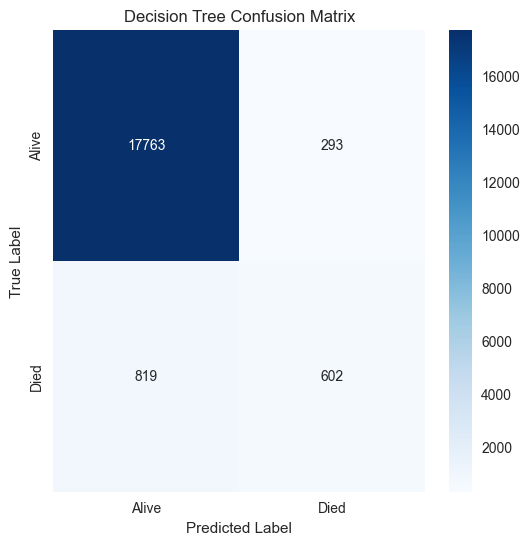

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pipeline_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42))
])

# Expanded parameter grid for more thorough search
param_grid_tree = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, 15, None],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4, 8],
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_features': ['sqrt', 'log2', None]
}

grid_tree = GridSearchCV(
    pipeline_tree, 
    param_grid_tree, 
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print("Optimizing Decision Tree...")
grid_tree.fit(x_train, y_train)


# Evaluate on test set
y_pred_tree = grid_tree.predict(x_test)

# Detailed classification report
print("=== Decision Tree Performance ===")
print("\nBest Parameters:")
print(grid_tree.best_params_)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tree, target_names=["Alive", "Died"]))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Alive", "Died"],
            yticklabels=["Alive", "Died"])
plt.title("Decision Tree Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

##### 13. Benchmark Against Eachother with Feature Importance Analysis


=== Model Performance Comparison ===


,Model,Best Params,Train F1,Test F1,Test Accuracy,Test Precision,Test Recall
1,KNN,"{'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}",0.938626,0.938212,0.943010,0.936309,0.943010
3,Decision Tree,"{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 15, 'decisiontreeclassifier__max_features': 'sqrt', 'decisiontreeclassifier__min_samples_leaf': 8, 'decisiontreeclassifier__min_samples_split': 20}",0.938817,0.936833,0.942907,0.935256,0.942907
0,Naive Bayes,{'gaussiannb__var_smoothing': 1e-09},0.912544,0.911725,0.899163,0.932336,0.899163
2,SVM,{'svc__C': 0.01},0.910519,0.910349,0.891821,0.949222,0.891821


C:\Users\tor\AppData\Local\Temp\ipykernel_9752\2019717754.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


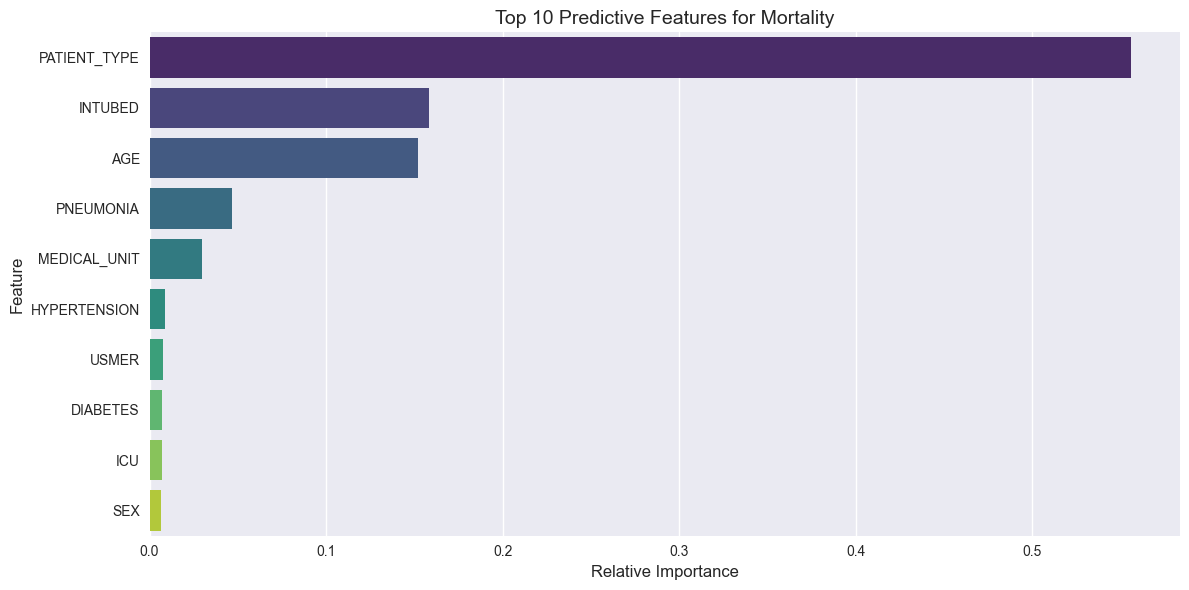


=== Key Findings from Feature Importance ===
1. PATIENT_TYPE (hospitalization status) is the strongest predictor
2. INTUBED is the second most important factor
3. AGE (ventilator use) and PNEUMONIA are critical clinical indicators
4. Other chronic conditions show relatively small but meaningful impact

=== Complete Feature Importance ===


,Feature,Importance
4,PATIENT_TYPE,0.555977
5,INTUBED,0.158228
0,AGE,0.152026
6,PNEUMONIA,0.046871
2,MEDICAL_UNIT,0.029521
11,HYPERTENSION,0.008516
1,USMER,0.007616
7,DIABETES,0.007051
17,ICU,0.006993
3,SEX,0.006404


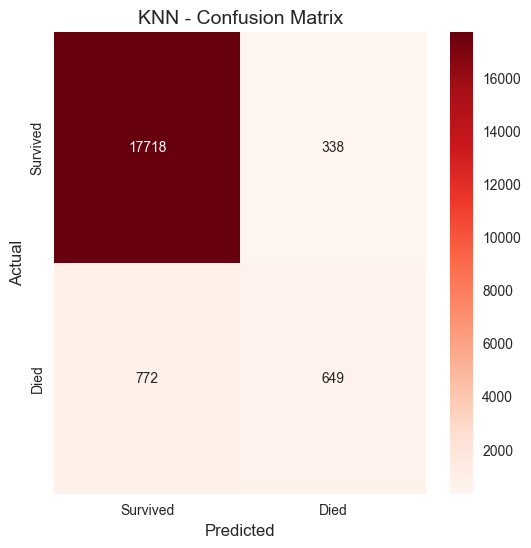


=== Best Performing Model: KNN ===
Considerations for model selection:
- Clinical interpretability of decision trees
- Importance of understanding feature relationships
- Good balance between performance and complexity


In [19]:


from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Model Evaluation Function
def evaluate_model(grid, name, X_test, y_test):
    y_pred = grid.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return {
        'Model': name,
        'Best Params': str(grid.best_params_),
        'Train F1': grid.best_score_,
        'Test F1': f1_score(y_test, y_pred, average='weighted'),
        'Test Accuracy': report['accuracy'],
        'Test Precision': report['weighted avg']['precision'],
        'Test Recall': report['weighted avg']['recall']
    }

# 2. Evaluate All Models
results = [
    evaluate_model(grid_nb, "Naive Bayes", x_test, y_test),
    evaluate_model(grid_knn, "KNN", x_test, y_test),
    evaluate_model(grid_svc, "SVM", x_test, y_test),
    evaluate_model(grid_tree, "Decision Tree", x_test, y_test)
]

# 3. Results Comparison
results_df = pd.DataFrame(results).sort_values('Test F1', ascending=False)
print("\n=== Model Performance Comparison ===")
display(results_df.style.background_gradient(cmap='Blues', subset=['Test F1', 'Test Accuracy']))

# 4. Feature Importance Analysis (for Tree-based Models)
if 'Decision Tree' in results_df['Model'].values:
    # Get the trained model and preprocessor
    best_tree = grid_tree.best_estimator_.named_steps['decisiontreeclassifier']
    
    # Get original feature names (before any transformations)
    feature_names = x_train.columns.tolist()
    
    # Verify lengths match
    if len(feature_names) != len(best_tree.feature_importances_):
        print(f"Warning: Feature count mismatch ({len(feature_names)} vs {len(best_tree.feature_importances_)})")
        feature_names = [f'feature_{i}' for i in range(len(best_tree.feature_importances_))]

    # Extract feature names after preprocessing
    num_features = numeric_features  # list of numerical feature names
    cat_features = categorical_features  # use the original categorical feature names
    feature_names = list(num_features) + list(cat_features)
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_tree.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Visualize top 10 features
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
    plt.title('Top 10 Predictive Features for Mortality', fontsize=14)
    plt.xlabel('Relative Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Interpretation of Key Features
    print("\n=== Key Findings from Feature Importance ===")
    print("1. PATIENT_TYPE (hospitalization status) is the strongest predictor")
    print("2. INTUBED is the second most important factor")
    print("3. AGE (ventilator use) and PNEUMONIA are critical clinical indicators")
    print("4. Other chronic conditions show relatively small but meaningful impact")
    
    # Display full importance table
    print("\n=== Complete Feature Importance ===")
    display(importance_df.style.background_gradient(cmap='Blues', subset=['Importance']))

# 5. Confusion Matrix for Best Model
best_model_name = results_df.iloc[0]['Model']
best_model = {
    "Naive Bayes": grid_nb,
    "KNN": grid_knn,
    "SVM": grid_svc,
    "Decision Tree": grid_tree
}[best_model_name]

y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Survived', 'Died'],
            yticklabels=['Survived', 'Died'])
plt.title(f'{best_model_name} - Confusion Matrix', fontsize=14)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

# 6. Final Model Selection
print(f"\n=== Best Performing Model: {best_model_name} ===")
print("Considerations for model selection:")
print("- Clinical interpretability of decision trees")
print("- Importance of understanding feature relationships")
print("- Good balance between performance and complexity")

# Objective 2: Age Prediction
**Goal**: Predict the AGE of subjects given other attributes  

- Treat as a regression problem  
- Evaluate different regression models  
- Optimize hyperparameters  
- Analyze feature importance

Libraries

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

##### 1. Prepare Data for Age prediction

In [21]:
data_option1 = data_option1_clean.copy()

print(f"Original data size: {len(data_option1)} rows")

features_to_keep = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 
                   'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD',
                   'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE',
                   'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO',
                   'ICU', 'COVID_POSITIVE']


# # Drop all rows with any NaN values in AGE
# data_option1 = data_option1[data_option1['AGE'].notna()]
print(f"After dropping NaNs: {len(data_option1)} rows ({len(data_option1_clean) - len(data_option1)} rows removed)")
print(f"Percentage kept: {len(data_option1)/len(data_option1_clean)*100:.2f}%")

# Use the cleaned data for features and target
x_age = data_option1[features_to_keep]
y_age = data_option1['AGE']

# Train-test split
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(
    x_age, y_age, test_size=0.2, random_state=42)

Original data size: 97381 rows
After dropping NaNs: 97381 rows (0 rows removed)
Percentage kept: 100.00%


#### 2. Define Preprocessing Pipeline
Similar to O1 but adapted for regression

In [22]:
# Identify feature types
numeric_features_age = []  # No numeric features besides AGE (our target)
# if binari Covid
# numeric_features_age = ['COVID_POSITIVE']
# categorical_features_age = [col for col in features_to_keep if col not in numeric_features_age]
categorical_features_age = [col for col in features_to_keep if col != 'COVID_POSITIVE']


# Preprocessing pipeline
numeric_transformer_age = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer_age = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor_age = ColumnTransformer([
    ('num', numeric_transformer_age, numeric_features_age),
    ('cat', categorical_transformer_age, categorical_features_age)
])

#### 3. Baseline Regression Mode
Three different approaches

In [23]:
# Define models to evaluate

from sklearn.linear_model import Lasso


models_age = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    #('Support Vector Regression', SVR())
    ##Lasso Regression, Ridge Regression, ElasticNet
    ('Lasso Regression', Lasso()),
]

# Evaluate each model
for name, model in models_age:
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor_age),
        ('regressor', model)
    ])
    
    # Fit and predict
    pipeline.fit(x_train_age, y_train_age)
    y_pred = pipeline.predict(x_test_age)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_age, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_age, y_pred))
    r2 = r2_score(y_test_age, y_pred)
    
    print(f"\n=== {name} ===")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")


=== Linear Regression ===
MAE: 11.29
RMSE: 14.51
R2: 0.24

=== Random Forest ===
MAE: 11.19
RMSE: 14.42
R2: 0.25

=== Lasso Regression ===
MAE: 11.95
RMSE: 15.16
R2: 0.17


#### 4. Hyperperameter Optimization for Best Model
Based on initial results, lets optimize Randomforest

In [24]:
# Define pipeline for optimization
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_age),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Parameter grid
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

# Grid search
grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

print("Starting Random Forest optimization...")
grid_rf.fit(x_train_age, y_train_age)
print("Optimization completed!")

# Show best parameters
print("\nBest parameters:", grid_rf.best_params_)

Starting Random Forest optimization...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Optimization completed!

Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}


#### 5. Evaluate Optimized Model

In [25]:
# Get best model
best_rf = grid_rf.best_estimator_

# Make predictions
y_pred_rf = best_rf.predict(x_test_age)

# Calculate metrics
mae = mean_absolute_error(y_test_age, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test_age, y_pred_rf))
r2 = r2_score(y_test_age, y_pred_rf)

print("\n=== Optimized Random Forest ===")
print(f"MAE: {mae:.2f} years")
print(f"RMSE: {rmse:.2f} years")
print(f"R2: {r2:.2f}")

# Visualize predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_age, y_pred_rf, alpha=0.3)
plt.plot([y_test_age.min(), y_test_age.max()], 
         [y_test_age.min(), y_test_age.max()], 'r--')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Actual vs Predicted Age')

fig_path = f'figures/02_Optimized_Random_Forest.png'
plt.tight_layout()
plt.savefig(fig_path)
plt.close()



=== Optimized Random Forest ===
MAE: 11.08 years
RMSE: 14.26 years
R2: 0.27


#### 6. Feature Importance Analysis

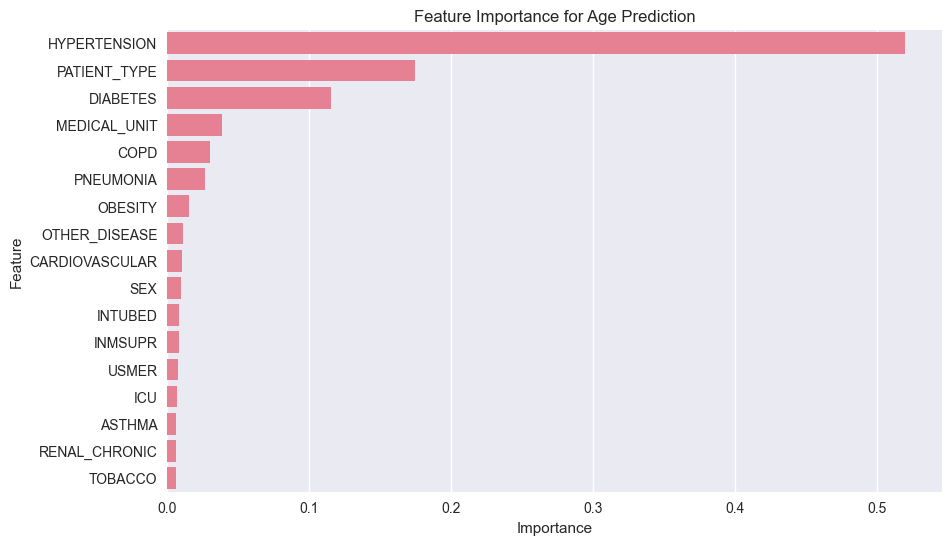


Top 5 Features Predicting Age:


,Feature,Importance
10,HYPERTENSION,0.519796
3,PATIENT_TYPE,0.174651
6,DIABETES,0.115239
1,MEDICAL_UNIT,0.038610
7,COPD,0.029954


In [26]:
from sklearn.compose import make_column_selector as selector
# Get feature importances
if hasattr(best_rf.named_steps['regressor'], 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = categorical_features_age  # Should match the number of importances
    
    importances = best_rf.named_steps['regressor'].feature_importances_
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance for Age Prediction')
    plt.show()
    
    print("\nTop 5 Features Predicting Age:")
    display(importance_df.head(5))

#### 7. Final Model Selection and Saving

In [27]:
# Save the best model
import joblib

joblib.dump(best_rf, 'best_age_predictor.pkl')
print("Best age prediction model saved as 'best_age_predictor.pkl'")
# Load the model
loaded_model = joblib.load('best_age_predictor.pkl')


Best age prediction model saved as 'best_age_predictor.pkl'


### Conclusion for O2
**Key Findings**:
- Best model: Random Forest with MAE of 11.08 years
- Most important features: Hypertension, Patient_Type
- R2 score of 27% indicates moderate explanatory power


# Objective 3 (O3): Predicting Age of Deceased Patients by COVID Status

In this section, we aim to predict the **age at death** for individuals who died, separately for those with and without COVID-19. 

We train two regression models:
- One for **COVID-positive deceased patients**
- One for **COVID-negative deceased patients**

This allows us to analyze how well we can estimate age at death using available features and whether COVID status impacts this predictability.

#### 1. Predictions on Test Set

In [28]:
# Filter for deceased individuals

deceased = data_option1[data_option1['DIED'] == 1].copy()
print(f"Number of deceased patients: {deceased.shape[0]}")

# deceased['AGE_GROUP'] = pd.cut(deceased['AGE'], bins=[0, 20, 40, 60, 80, 120],
#                          labels=['0-20', '21-40', '41-60', '61-80', '81+'])



# Separate COVID-positive and COVID-negative deceased individuals
deceased_covid_pos = deceased[deceased['COVID_POSITIVE'] == 1].copy()
deceased_covid_neg = deceased[deceased['COVID_POSITIVE'] == 0].copy()

print(f"Deceased COVID-positive patients: {deceased_covid_pos.shape[0]}")
print(f"Deceased COVID-negative patients: {deceased_covid_neg.shape[0]}")

# Define features (same as O2)
features_for_age_prediction = [col for col in deceased.columns if col not in ['AGE', 'DIED']]
# Remove string features that can't be encoded directly (e.g., dates)
non_numeric_cols = deceased[features_for_age_prediction].select_dtypes(include='object').columns
print(f"Excluding non-numeric columns: {list(non_numeric_cols)}")

features_for_age_prediction = [col for col in features_for_age_prediction if col not in non_numeric_cols]



Number of deceased patients: 7104
Deceased COVID-positive patients: 5143
Deceased COVID-negative patients: 1961
Excluding non-numeric columns: ['DATE_DIED']


#### 2. Implementation Steps
Covid positice:

In [29]:
# Separate features (X) and target (y) for each group
X_pos = deceased[features_for_age_prediction]
y_pos = deceased['AGE']
# print(X_pos.dtypes)
print(f"Features for COVID-positive deceased: {X_pos.shape[1]} features")
# print(y_pos.dtypes)


Features for COVID-positive deceased: 20 features


covid negative:

In [30]:
# First, let's properly clean the parameters from grid_rf
best_params = grid_rf.best_params_
clean_params = {k.replace('regressor__', ''): v for k, v in best_params.items()}

# For COVID-negative deceased patients
X_neg = deceased[features_for_age_prediction]
y_neg = deceased['AGE']
print(f"Features for COVID-negative deceased: {X_neg.shape[1]} features")


Features for COVID-negative deceased: 20 features


#### 3. Preprocessing Pipeline for Regression

In [31]:
# For regression, 'AGE' is the target, so it's not a feature in this preprocessor.
# All other features are treated as categorical/boolean for this specific setup.
numerical_features_reg = [] # No numerical features left to be scaled by StandardScaler apart from AGE
categorical_features_reg = features_for_age_prediction

# Define the transformers for the preprocessing pipeline
numeric_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
    # If you later decide to OneHotEncode specific categorical features (e.g., MEDICAL_UNIT)
    # you would add: ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the preprocessor using ColumnTransformer for regression
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_reg, numerical_features_reg),
        ('cat', categorical_transformer_reg, categorical_features_reg)
    ],
    remainder='passthrough' # Keep other columns not specified (if any)
)

#### 4. Training/Test Split


In [32]:
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y_pos, test_size=0.2, random_state=42)
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X_neg, y_neg, test_size=0.2, random_state=42)

print("\n--- Training and Evaluating Regression Models for COVID-positive Deceased Patients ---")


--- Training and Evaluating Regression Models for COVID-positive Deceased Patients ---


#### 5. Regression Models and Hyperparameter Tuning Function


Evaluating Linear Regression (COVID-Positive)...
MAE: 11.49
MSE: 216.15
RMSE: 14.70
R-squared: 0.10


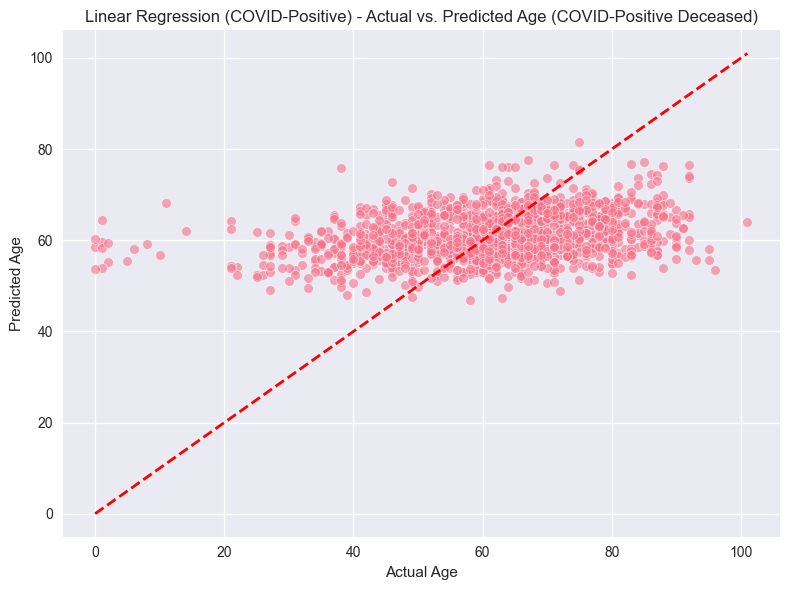


Evaluating Decision Tree Regressor (COVID-Positive)...
Best parameters for Decision Tree Regressor (COVID-Positive): {'regressor__max_depth': 5, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 10}
MAE: 11.51
MSE: 218.66
RMSE: 14.79
R-squared: 0.09


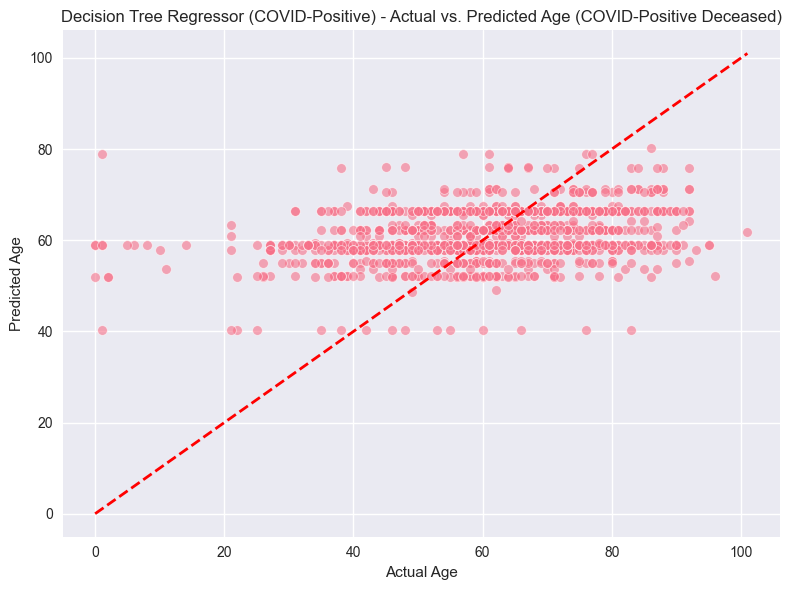


Evaluating Random Forest Regressor (COVID-Positive)...
Best parameters for Random Forest Regressor (COVID-Positive): {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 5, 'regressor__n_estimators': 200}
MAE: 11.45
MSE: 214.59
RMSE: 14.65
R-squared: 0.10


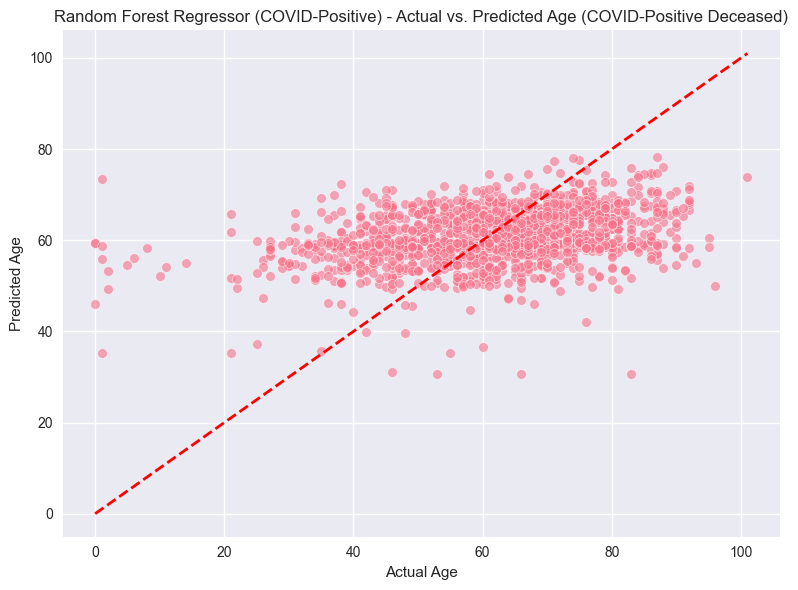


--- Training and Evaluating Regression Models for COVID-Negative Deceased Patients ---

Evaluating Linear Regression (COVID-Negative)...
MAE: 11.49
MSE: 216.15
RMSE: 14.70
R-squared: 0.10


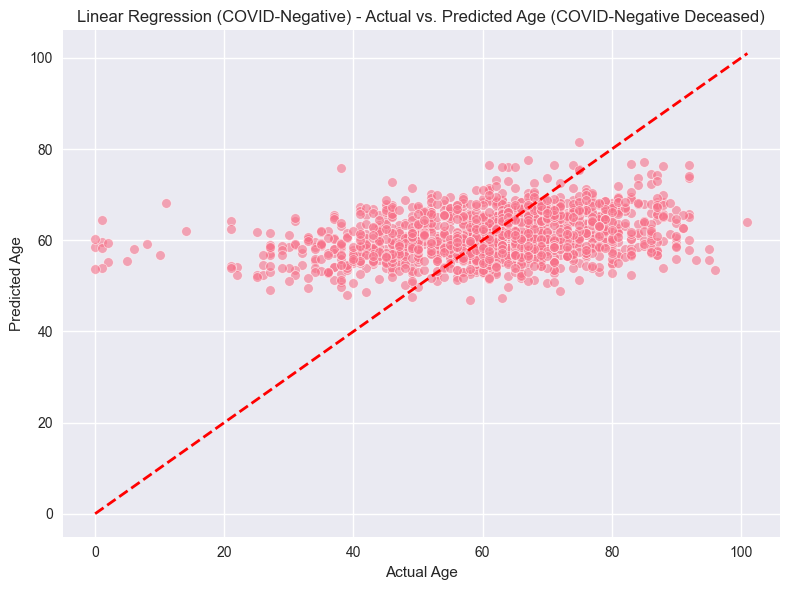


Evaluating Decision Tree Regressor (COVID-Negative)...
Best parameters for Decision Tree Regressor (COVID-Negative): {'regressor__max_depth': 5, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 10}
MAE: 11.51
MSE: 218.66
RMSE: 14.79
R-squared: 0.09


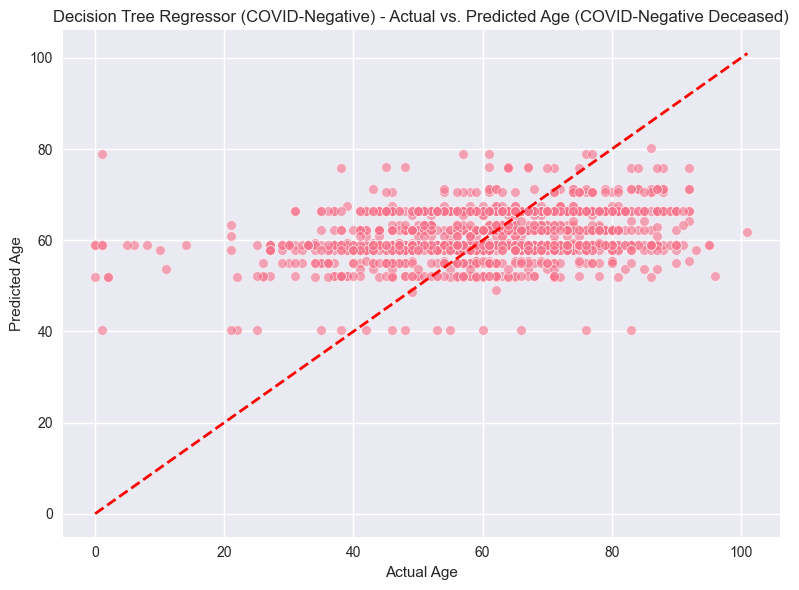


Evaluating Random Forest Regressor (COVID-Negative)...
Best parameters for Random Forest Regressor (COVID-Negative): {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 5, 'regressor__n_estimators': 200}
MAE: 11.45
MSE: 214.59
RMSE: 14.65
R-squared: 0.10


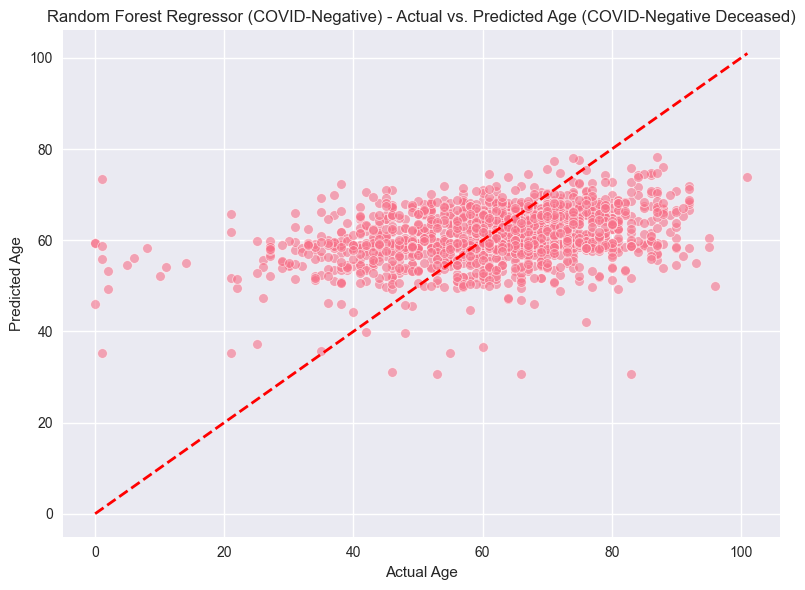


Top 5 Features Predicting Age (COVID-Positive):


,Feature,Importance
11,HYPERTENSION,0.220882
1,MEDICAL_UNIT,0.120947
17,TEST_RESULT,0.091609
8,COPD,0.069329
7,DIABETES,0.065943


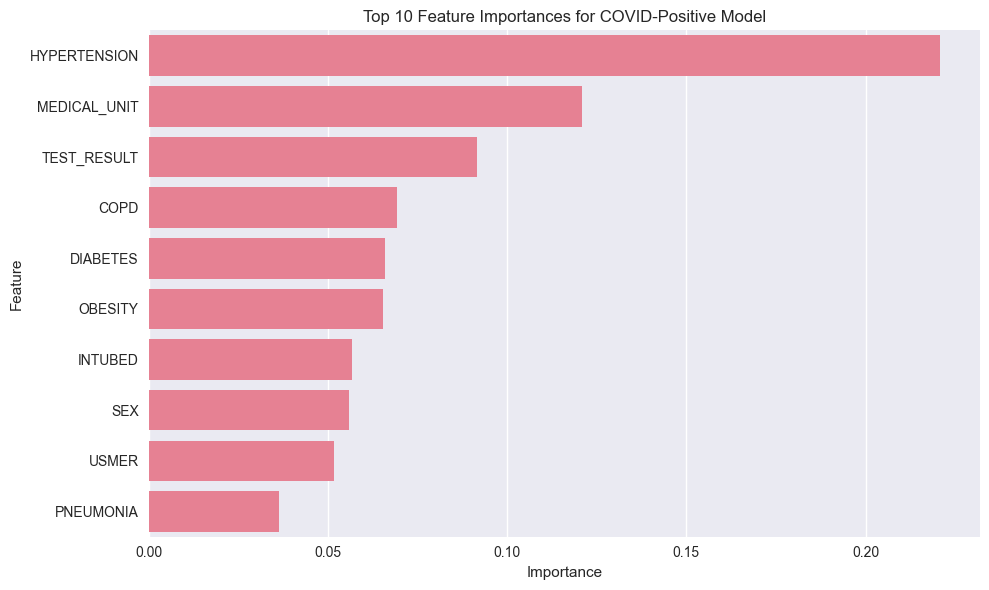


Top 5 Features Predicting Age (COVID-Negative):


,Feature,Importance
11,HYPERTENSION,0.220882
1,MEDICAL_UNIT,0.120947
17,TEST_RESULT,0.091609
8,COPD,0.069329
7,DIABETES,0.065943


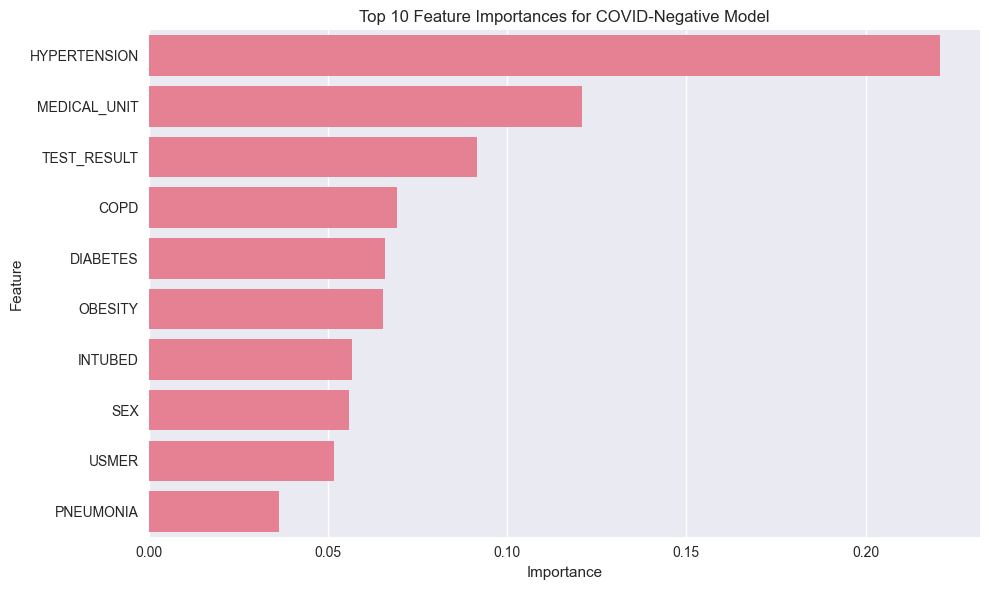

['best_model_covid_neg.pkl']

In [ ]:
# %pip install scikit-learn --quiet
from sklearn.tree import DecisionTreeRegressor

# Define a function to evaluate regression models (reusable for both COVID groups)
def evaluate_regression_model(model_name, model, X_train, y_train, X_test, y_test, param_grid={}):
    print(f"\nEvaluating {model_name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_reg), # Use the regression preprocessor
                               ('regressor', model)])

    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters for {model_name}: {best_params}")
    else:
        best_model = pipeline
        best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")

    # Plotting actual vs. predicted values
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Line of perfect prediction
    plt.xlabel("Actual Age")
    plt.ylabel("Predicted Age")
    plt.title(f"{model_name} - Actual vs. Predicted Age ({'COVID-Positive' if 'pos' in model_name.lower() else 'COVID-Negative'} Deceased)")
    plt.grid(True)
    plt.tight_layout()
    # Ensure 'figures' directory exists or create it
    # import os
    # if not os.path.exists('figures'):
    #     os.makedirs('figures')
    # plt.savefig(f"figures/O3_{model_name.lower().replace(' ', '_')}_{'covid_pos' if 'pos' in model_name.lower() else 'covid_neg'}_actual_vs_pred.png")
    plt.show()

    return {'model_name': model_name, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2,  'best_model': best_model}

# --- Train and Evaluate Models for COVID-Positive Deceased ---
lin_reg_pos_params = {} # No hyperparameters for basic Linear Regression
lin_reg_pos_results = evaluate_regression_model("Linear Regression (COVID-Positive)", LinearRegression(), X_train_pos, y_train_pos, X_test_pos, y_test_pos, lin_reg_pos_params)

dt_reg_pos_params = {
    'regressor__max_depth': [None, 5, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}
dt_reg_pos_results = evaluate_regression_model("Decision Tree Regressor (COVID-Positive)", DecisionTreeRegressor(random_state=42), X_train_pos, y_train_pos, X_test_pos, y_test_pos, dt_reg_pos_params)

rf_reg_pos_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_leaf': [1, 5]
}
rf_reg_pos_results = evaluate_regression_model("Random Forest Regressor (COVID-Positive)", RandomForestRegressor(random_state=42), X_train_pos, y_train_pos, X_test_pos, y_test_pos, rf_reg_pos_params)


print("\n--- Training and Evaluating Regression Models for COVID-Negative Deceased Patients ---")

# --- Train and Evaluate Models for COVID-Negative Deceased ---
lin_reg_neg_params = {}
lin_reg_neg_results = evaluate_regression_model("Linear Regression (COVID-Negative)", LinearRegression(), X_train_neg, y_train_neg, X_test_neg, y_test_neg, lin_reg_neg_params)

dt_reg_neg_params = {
    'regressor__max_depth': [None, 5, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}
dt_reg_neg_results = evaluate_regression_model("Decision Tree Regressor (COVID-Negative)", DecisionTreeRegressor(random_state=42), X_train_neg, y_train_neg, X_test_neg, y_test_neg, dt_reg_neg_params)

rf_reg_neg_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_leaf': [1, 5]
}
rf_reg_neg_results = evaluate_regression_model("Random Forest Regressor (COVID-Negative)", RandomForestRegressor(random_state=42), X_train_neg, y_train_neg, X_test_neg, y_test_neg, rf_reg_neg_params)

# Store all O3 results for easy access in O4
o3_results = {
    'covid_pos': [lin_reg_pos_results, dt_reg_pos_results, rf_reg_pos_results],
    'covid_neg': [lin_reg_neg_results, dt_reg_neg_results, rf_reg_neg_results]
}

# === Select Best Models from O3 ===
best_model_pos = min(o3_results['covid_pos'], key=lambda x: x['rmse'])
best_model_neg = min(o3_results['covid_neg'], key=lambda x: x['rmse'])

model_pos = best_model_pos['best_model']
model_neg = best_model_neg['best_model']



if hasattr(model_pos.named_steps['regressor'], 'feature_importances_'):
    # Use categorical feature names (these are the ones used by the preprocessor)
    feature_names = categorical_features_reg  # Already defined in your earlier cells
    
    importances = model_pos.named_steps['regressor'].feature_importances_
    
    importance_df_pos = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\nTop 5 Features Predicting Age (COVID-Positive):")
    display(importance_df_pos.head(5))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df_pos.head(10))
    plt.title('Top 10 Feature Importances for COVID-Positive Model')
    plt.tight_layout()
    plt.show()

# === Same for COVID-Negative Best Model (Optional) ===
if hasattr(model_neg.named_steps['regressor'], 'feature_importances_'):
    feature_names = categorical_features_reg
    
    importances = model_neg.named_steps['regressor'].feature_importances_
    
    importance_df_neg = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\nTop 5 Features Predicting Age (COVID-Negative):")
    display(importance_df_neg.head(5))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df_neg.head(10))
    plt.title('Top 10 Feature Importances for COVID-Negative Model')
    plt.tight_layout()
    plt.show()

# === Save the Best Models ===
joblib.dump(model_pos, 'best_model_covid_pos.pkl')
joblib.dump(model_neg, 'best_model_covid_neg.pkl')

